In [1]:
cd ..

/home/mffang/workspace/Poisson-regression


In [2]:
# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

import RADOM
print(RADOM.__version__)

from RADOM.inference import Trajectory
from RADOM.poisson_mixture import PoissonMixture
from RADOM.gamma_poisson_mixture import GammaPoissonMixture
from RADOM.preprocess import *
from RADOM.plotting import *

2023.04.19.16


In [3]:
from scipy.stats import spearmanr
import scanpy as sc
import scvelo as scv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cmasher as cmr
from tqdm import tqdm

# Load data

```
import synapseclient 
import synapseutils 
 
syn = synapseclient.Synapse() 
syn.login('mffang','password')
files = synapseutils.syncFromSynapse(syn, 'syn23667437', path="./data/Kannan") 

```

In [4]:
data_dir = "data/Kannan/"
###Generate Main adata object
alldata = sc.read(data_dir+"python_spliced.csv",first_column_names=None).transpose()

#Obs and vars
phenotype = pd.read_csv(data_dir+"python_pheno.csv", index_col = 0)
alldata.obs = phenotype
alldata.obs['timepoint'] = alldata.obs['timepoint'].astype('category')
alldata.obs['timepoint'].cat.reorder_categories(['e14', 'e18', 'p0', 'p1', 'p4', 'p8', 'p11', 'p14', 'p15', 'p18', 'p22', 'p28', 'p35', 'p56', 'p84', 'D8', 'D10', 'D12', 'D15', 'D18', 'D25', 'D30', 'D45'], inplace=True)

#Spliced and unspliced matrices
unspliced = sc.read(data_dir+"python_unspliced.csv",first_column_names=None).transpose().X
spliced = alldata.X
alldata.layers["spliced"] = spliced
alldata.layers["unspliced"] = unspliced

#Add on mnnCorrected PCA plot and UMAP (this is from the cds_branched object in the R code, which contains both the in vivo and in vitro samples)
alldata.obsm["X_umap"] = np.genfromtxt(data_dir+"python_umap.csv", delimiter = ",")
alldata.obsm["X_pca"] = np.genfromtxt(data_dir+"python_pca.csv", delimiter = ",")

In [5]:
###Analysis for in vivo data

#Construct the adata_invivo object
adata_invivo = alldata[alldata.obs["group"] == "in vivo"]
adata_invivo.obsm["X_umap"] = np.genfromtxt(data_dir+"python_umap_invivo.csv", delimiter = ",")
adata_invivo.obsm["X_pca"] = np.genfromtxt(data_dir+"python_pca_invivo.csv", delimiter = ",")
#In the default scvelo vignette, you filter genes based on the highest dispersion genes. In my case, however, logically I thought it made more sense to do this based on the genes that are differentially expressed over pseudotime because a) I have this data already and b) it makes more biological sense. I am specifically interested in dynamics associated with genes changing over the maturation trajectory; you could imagine genes with high dispersion but related to some other aspect of biology (or a batch effect) that confounds our results here. Hence, I subset based on differentially expressed genes.
#pseudo_ids_invivo = pd.read_table(data_dir+"pseudo_ids_invivo.txt", sep = ",")
#adata_invivo = adata_invivo[:,adata_invivo.var.index.isin(pseudo_ids_invivo["Genes"])]
adata_invivo

AnnData object with n_obs × n_vars = 1596 × 29379
    obs: 'i7', 'barcode', 'library', 'batch', 'batch_date', 'timepoint', 'isolation_date', 'group', 'mouse', 'line', 'size', 'timepoint2', 'study', 'depth', 'genes', 'entropy', 'top5', 'top5_norm', 'depth_norm', 'mito', 'mito_all', 'ribo', 'cm_score', 'max_score', 'max_celltype', 'good_cell', 'data', 'cellname', 'other_meta', 'include_dataset', 'reason', 'isolation', 'sequencing', 'mapping', 'datatype', 'species', 'sample_type', 'full_label', 'ercc', 'Size_Factor', 'individual_pseudotime'
    obsm: 'X_umap', 'X_pca'
    layers: 'spliced', 'unspliced'

# In vivo

In [6]:
adata = adata_invivo

In [7]:
adata.obs

,i7,barcode,library,batch,batch_date,timepoint,isolation_date,group,mouse,line,...,isolation,sequencing,mapping,datatype,species,sample_type,full_label,ercc,Size_Factor,individual_pseudotime
TAAGGCGAATATAG,TAAGGCGA,ATATAG,36,1,May 2019,e14,2/13/2019,in vivo,1.0,NaN,...,LP-FACS,mcSCRB-seq,kallisto|bustools,UMIs,mouse,in vivo,mouse in vivo,711,0.725651,0.096965
AGGCAGAAATATAG,AGGCAGAA,ATATAG,34,1,May 2019,e14,2/13/2019,in vivo,1.0,NaN,...,LP-FACS,mcSCRB-seq,kallisto|bustools,UMIs,mouse,in vivo,mouse in vivo,208,3.008340,0.006420
GGACTCCTATATAG,GGACTCCT,ATATAG,32,1,May 2019,e14,2/13/2019,in vivo,1.0,NaN,...,LP-FACS,mcSCRB-seq,kallisto|bustools,UMIs,mouse,in vivo,mouse in vivo,232,1.304101,0.021296
TAGGCATGATATAG,TAGGCATG,ATATAG,31,1,May 2019,e14,2/13/2019,in vivo,1.0,NaN,...,LP-FACS,mcSCRB-seq,kallisto|bustools,UMIs,mouse,in vivo,mouse in vivo,277,1.960681,0.006005
CTCTCTACATATAG,CTCTCTAC,ATATAG,30,1,May 2019,e14,2/13/2019,in vivo,1.0,NaN,...,LP-FACS,mcSCRB-seq,kallisto|bustools,UMIs,mouse,in vivo,mouse in vivo,363,1.356026,0.076512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AGGACCGCTGGCCG,AGGACCGC,TGGCCG,18,2,November\n2019,p84,8/30/2019,in vivo,2.0,NaN,...,LP-FACS,mcSCRB-seq,kallisto|bustools,UMIs,mouse,in vivo,mouse in vivo,56,1.087883,0.899187
CACGAGTTTGGCCG,CACGAGTT,TGGCCG,16,2,November\n2019,p84,8/30/2019,in vivo,2.0,NaN,...,LP-FACS,mcSCRB-seq,kallisto|bustools,UMIs,mouse,in vivo,mouse in vivo,45,1.382608,0.863573
CCACGGCCTGGCCG,CCACGGCC,TGGCCG,15,2,November\n2019,p84,8/30/2019,in vivo,2.0,NaN,...,LP-FACS,mcSCRB-seq,kallisto|bustools,UMIs,mouse,in vivo,mouse in vivo,97,0.823515,0.607304
ACATGTAATGGCCG,ACATGTAA,TGGCCG,14,2,November\n2019,p84,8/30/2019,in vivo,2.0,NaN,...,LP-FACS,mcSCRB-seq,kallisto|bustools,UMIs,mouse,in vivo,mouse in vivo,61,1.362065,0.991495


In [8]:
clusters = adata.obs["timepoint"]
Clusters = ['e14', 'e18', 'p0', 'p1', 'p4', 'p8', 'p11', 'p14', 'p15', 'p18', 'p22', 'p28', 'p35', 'p56', 'p84']

In [9]:
color_palette = ["#d3e4e2","#405759"]
from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=len(Clusters))

cell_colors = np.zeros((adata.n_obs,3))

for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    cell_colors[idx] = cmap_cluster(i)[:3]

In [10]:
x = adata_invivo.obsm['X_umap']

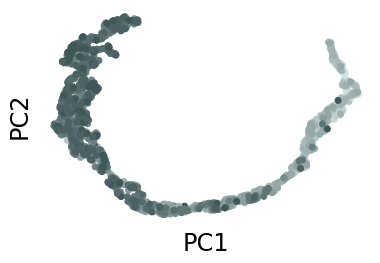

In [11]:
fig, ax = plt.subplots(1,1)
ax.scatter(x[:,0],x[:,1],c=cell_colors);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

In [12]:
marker_genes = ['Srf','Nfmue1']

# Select genes

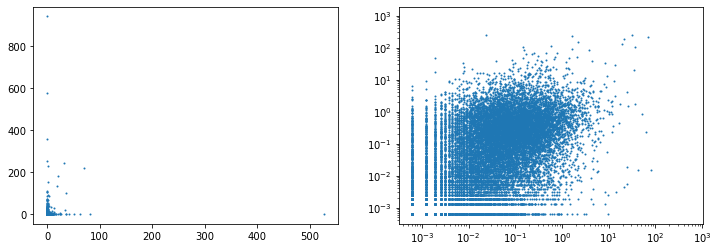

In [13]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(adata.layers['unspliced'].mean(0),adata.layers['spliced'].mean(0),s=1)
ax[1].scatter(adata.layers['unspliced'].mean(0),adata.layers['spliced'].mean(0),s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')

In [14]:
idx = (adata.layers["unspliced"].mean(0) > 0) 
U = adata.layers["unspliced"][:,idx]
n,p = U.shape
X = U
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
su = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total U counts =", str(su))


idx = adata.layers["spliced"].mean(0) > 0
S = adata.layers["spliced"][:,idx]
n,p = S.shape
X = S
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
ss = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total S counts =", str(ss))

idx = (adata.layers["spliced"].mean(0) > 0) | (adata.layers["unspliced"].mean(0) > 0)
U=adata.layers["unspliced"][:,idx]
S=adata.layers["spliced"][:,idx]
X = S + U
n,p = X.shape
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
s1 = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total counts =", str(s1))

X = U + S
X_total = X.sum(1)
s2 = (X_total.var()-X_total.mean())/X_total.mean()**2
print("s estimated by total counts =", str(s2))

s estimated by normalized covariance of total U counts = 4.925303556725837
s estimated by normalized covariance of total S counts = 2.1737964595813866
s estimated by normalized covariance of total counts = 3.9838982151887574
s estimated by total counts = 0.6968866839618854


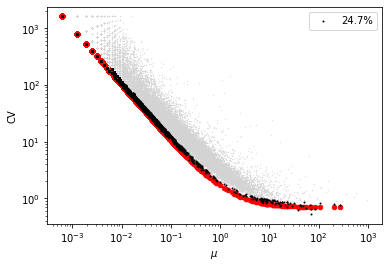

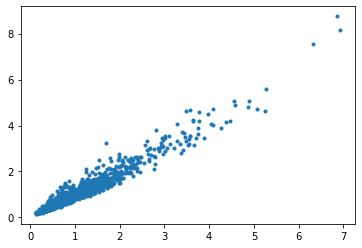

In [15]:
idx = (adata.layers["spliced"].mean(0) > 0) | (adata.layers["unspliced"].mean(0) > 0)
U=adata.layers["unspliced"][:,idx]
S=adata.layers["spliced"][:,idx]

X_bar = np.mean(U + S, axis=0)
X_var = np.var(U + S, axis=0)
a=1
s=s2
Pgene_mask = (X_bar > 0) & (X_var/(a*X_bar + s*X_bar**2) < 1.2)
Pgenes = adata.var_names[idx][Pgene_mask]

plt.scatter(X_bar[Pgene_mask], a/X_bar[Pgene_mask] + s, c='r', s=20)
plt.scatter(X_bar, X_var/X_bar**2,c='lightgray',alpha=1, s=0.1)
plt.scatter(X_bar[Pgene_mask], X_var[Pgene_mask]/X_bar[Pgene_mask]**2,c='k', s=1, label=str(np.around(100*np.sum(Pgene_mask)/len(X_bar),1))+"%")
plt.xlabel(r'$\mu$')
plt.ylabel(r'CV')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc="upper right")

read_depth =  (U + S)[:,Pgene_mask].sum(1)
rd = read_depth/read_depth.mean()

plt.figure()
plt.plot(rd,adata.X.mean(1)/adata.X.mean(),'.')

(1596, 172, 2)

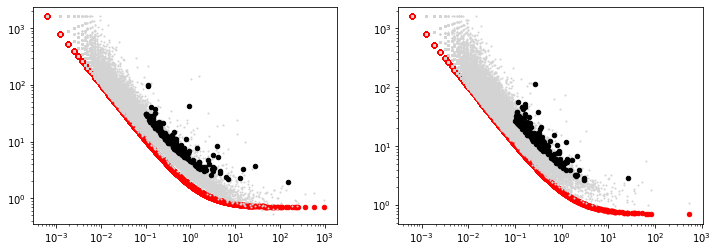

In [20]:
var_threshold = 2.5
U_mean = adata.layers["unspliced"].mean(0)
S_mean = adata.layers["spliced"].mean(0)
U_var = adata.layers["unspliced"].var(0)
S_var = adata.layers["spliced"].var(0)
fitted_idx = (U_mean > 0.1) & (S_mean > 0.1) \
    & (np.abs(np.log10(S_mean/U_mean)) < 2) \
    & (U_var/(a*U_mean + s2*U_mean**2) > var_threshold) \
    & (S_var/(a*S_mean + s2*S_mean**2) > var_threshold)

fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(S_mean, a/S_mean + s2, c='r', s=20)
ax[0].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=1)
ax[0].scatter(S_mean[fitted_idx], S_var[fitted_idx]/S_mean[fitted_idx]**2, c='k', s=20)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].scatter(U_mean, a/U_mean + s2, c='r', s=20)
ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=1)
ax[1].scatter(U_mean[fitted_idx], U_var[fitted_idx]/U_mean[fitted_idx]**2, c='k', s=20)
ax[1].set_xscale('log')
ax[1].set_yscale('log')

X=np.zeros((n,fitted_idx.sum(),2))
X[:,:,0]=adata.layers["unspliced"][:,fitted_idx]
X[:,:,1]=adata.layers["spliced"][:,fitted_idx]
fitted_genes=adata.var_names[fitted_idx]
X.shape

In [21]:
plot_idx = [np.where(fitted_genes==gene)[0] for gene in marker_genes]
plot_idx = np.concatenate(plot_idx).ravel()
print(fitted_genes[plot_idx])

Index([], dtype='object')


In [20]:
pp = min(10,len(plot_idx))
fix, ax = plt.subplots(1,pp,figsize=(6*pp,4))
for i in range(pp):
    j = plot_idx[i]
    ax[i].set_title(fitted_genes[j])
    ax[i].scatter(X[:,j,0]+np.random.normal(0,0.1,X.shape[0]),X[:,j,1]+np.random.normal(0,0.1,X.shape[0]),s=0.5,alpha=0.5) #,c=adata.obs['louvain'])

ValueError: Number of columns must be a positive integer, not 0

<Figure size 0x288 with 0 Axes>

# Mixtures fitting

In [22]:
cell_idx = clusters.isin(Clusters)
X_mix = X[cell_idx]

In [61]:
PM = PoissonMixture(n_components=3,verbose=0)
Q, elbo = PM.fit(X_mix,warm_start=False,read_depth=rd,epoch=10,n_init=5)
PM.weights

array([0.22803571, 0.35148674, 0.42047755])

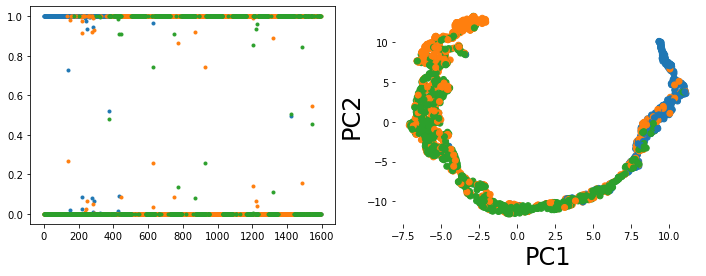

In [62]:
tab_colors = plt.cm.tab10(np.arange(10))
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(Q[np.argsort(clusters[cell_idx])],'.');
ax[1].scatter(x[cell_idx,0],x[cell_idx,1],c=tab_colors[np.argmax(Q,axis=1)]);
ax[1].set_xlabel('PC1',fontsize=24)
ax[1].set_ylabel('PC2',fontsize=24)
ax[1].set_frame_on(False)

# Trajectory fitting

In [29]:
elbos = {}
params={'r':rd,"lambda_tau":0,"lambda_a":0}

## Fine cluster

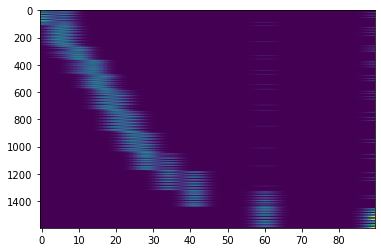

In [63]:
m = 90
grids = np.arange(m)
weight0 = 100*np.ones((adata.n_obs,m))
times = [0, 4, 6, 7, 10, 14, 17, 20, 21, 24, 28, 34, 41, 60, 90]
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    time = times[i]
    weight0[idx] = np.exp(-(grids-time)**2/10)
weight0=weight0/weight0.sum(axis=1,keepdims=True)
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
Q0[:,0,:] = weight0[:,None]
plt.imshow(weight0,aspect="auto")

In [96]:
topo = np.array([[0,1],[0,2]])
tau = (0,90) 
traj = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj = traj.fit(X,warm_start=True,fit_tau=True,params=params,Q=Q0,parallel=True,n_threads=10,epoch=10)#prior=Q0,
print(traj.elbos[-1])

AssertionError: 

[ 0. 90.]


AttributeError: 'Trajectory' object has no attribute 'Q'

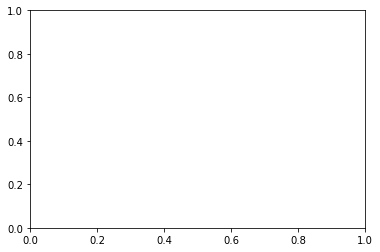

In [97]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

[]

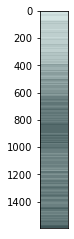

In [87]:
order = np.argsort(traj.Q[:,0]@traj.t)
cluster = np.zeros(adata.n_obs)
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    cluster[idx] = i
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
fig, ax = plt.subplots(1,1,figsize=(0.5,4))
ax.imshow(cluster[order,None],aspect="auto",cmap=cmap_cluster)
ax.set_xticks([])

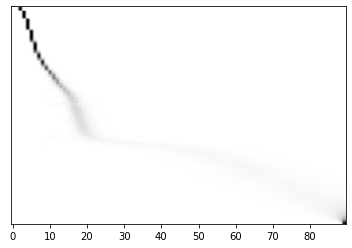

In [88]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax=plot_t(traj,l=0,ax=ax,order_cells=True)
ax.set_yticks([]);

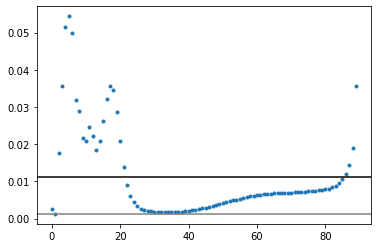

In [89]:
plt.plot(traj.Q[:,0].mean(0),'.')
plt.axhline(y=1/traj.m,c='k')
plt.axhline(y=0.1/traj.m,c='gray')

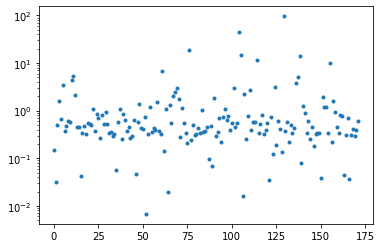

In [90]:
plt.plot(traj.theta[:,[-2]],'.')
plt.yscale('log')

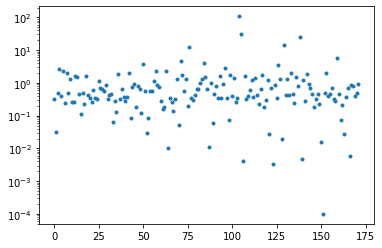

In [91]:
plt.plot(traj.theta[:,[-1]],'.')
plt.yscale('log')

In [92]:
plot_idx = np.arange(10)

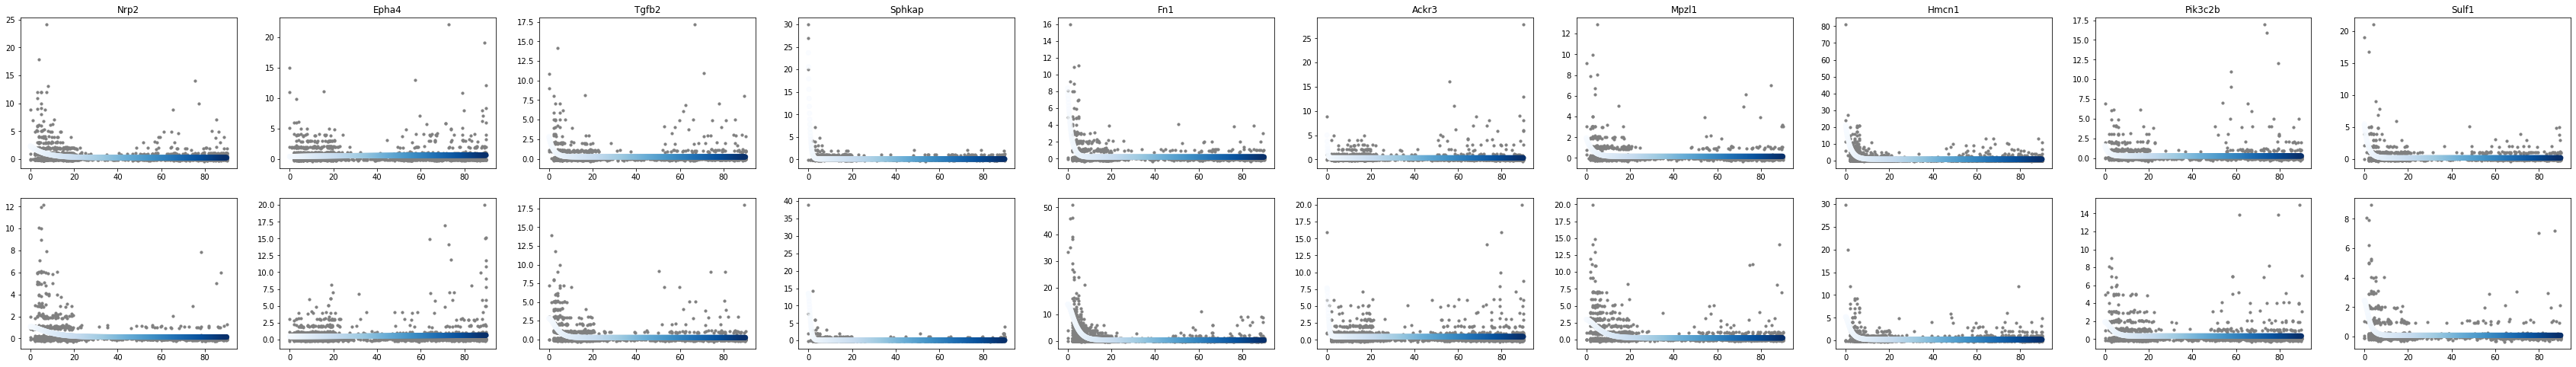

In [93]:
plot_y(traj,X=X,idx=plot_idx,gene_name=fitted_genes);

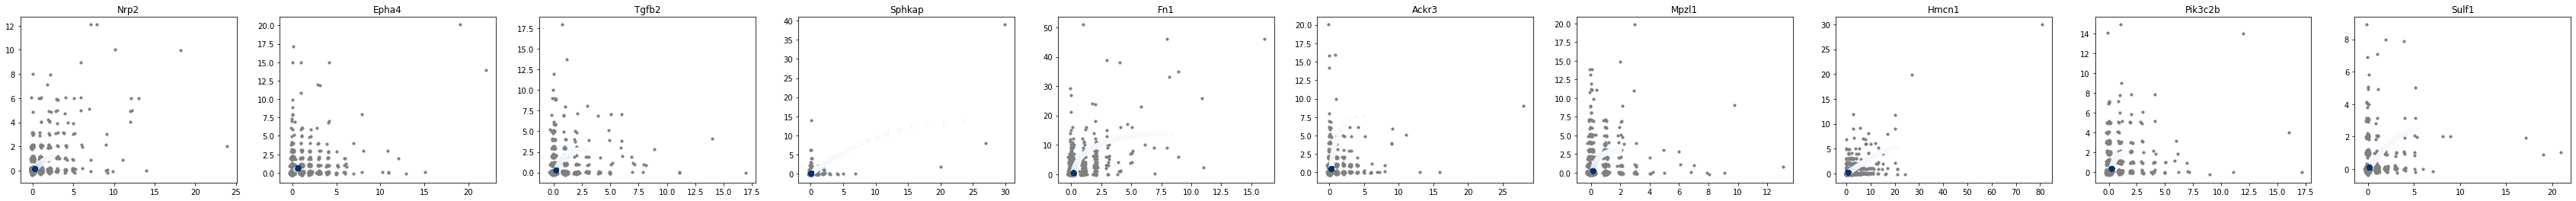

In [94]:
plot_phase(traj,X=X,idx=plot_idx,gene_name=fitted_genes);

In [205]:
n, p, _ = X.shape
up_mask = (traj.theta[:,2] > 2*traj.theta[:,1]) & (traj.theta[:,1] > 2*traj.theta[:,0])
print(up_mask.sum())
up_idx = np.arange(p)[up_mask]
plot_y(traj,X=X,idx=up_idx[:10],gene_name=fitted_genes);

0


ValueError: Number of columns must be a positive integer, not 0

<Figure size 0x576 with 0 Axes>

In [80]:
plot_marker_genes = ['Gata1','Gata2','Hba-x']

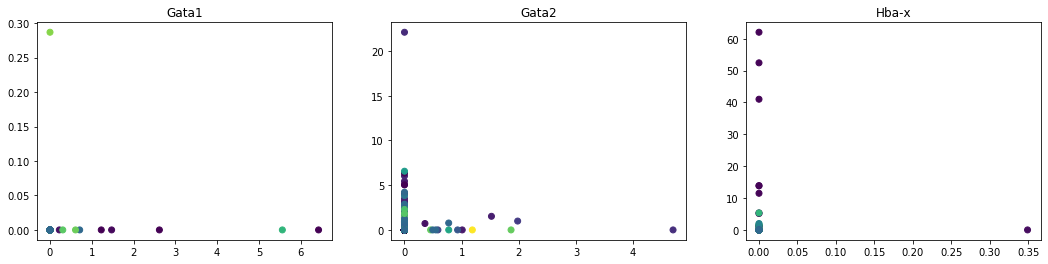

In [82]:
fig,ax = plt.subplots(1,len(plot_marker_genes),figsize=(6*len(plot_marker_genes),4))
for i,gene in enumerate(plot_marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[i].set_title(gene)
    ax[i].scatter(adata.layers["unspliced"][:,j]/rd,adata.layers["spliced"][:,j]/rd,c=traj.Q[:,0]@traj.t)

AttributeError: 'numpy.ndarray' object has no attribute 'toarray'

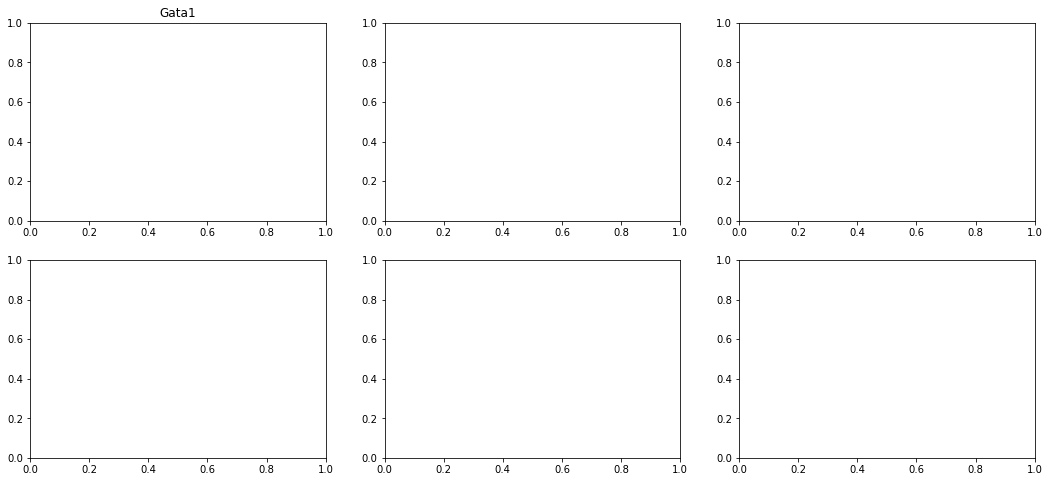

In [83]:
fig,ax = plt.subplots(2,len(plot_marker_genes),figsize=(6*len(plot_marker_genes),8))
for i,gene in enumerate(plot_marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[0,i].set_title(gene)
    ax[0,i].scatter(traj.Q[:,0]@traj.t,adata.layers["unspliced"].toarray()[:,j]/rd)
    ax[1,i].scatter(traj.Q[:,0]@traj.t,adata.layers["spliced"].toarray()[:,j]/rd)

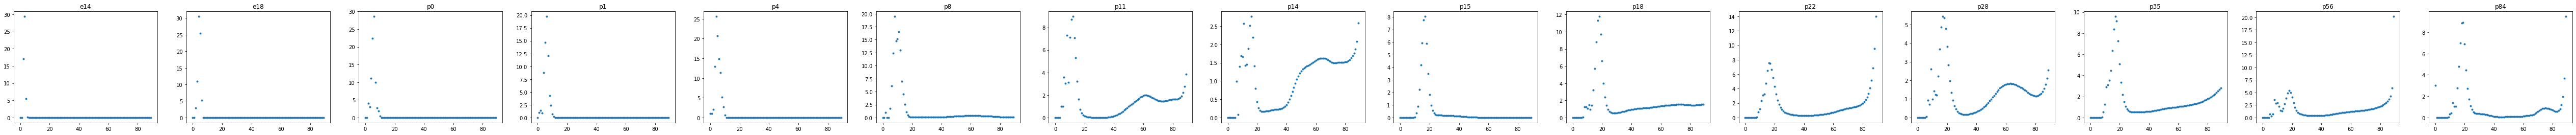

In [95]:
stages = Clusters
fig, ax = plt.subplots(1,len(stages),figsize=(6*len(stages),4))
for i,stage in enumerate(stages):
    idx = adata.obs["timepoint"].isin([stage])
    ax[i].plot(traj.Q[idx,0].sum(0),'.')
    ax[i].set_title(stage)

[Text(0, 0, 'α0'), Text(1, 0, 'α1'), Text(2, 0, 'α2')]

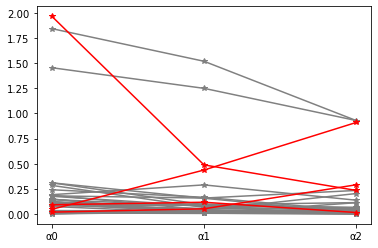

In [201]:
p=30
fig,ax = plt.subplots(1,1)
for j in range(p):
    ax.plot(traj.theta[j,[0,1,2]],'-*',color='gray')
for j in plot_idx:
    ax.plot(traj.theta[j,[0,1,2]],'-*',color='red')

x_label_list = ['α0', 'α1', 'α2']
ax.set_xticks([0,1,2])
ax.set_xticklabels(x_label_list)
#plt.yscale('log')

In [ ]:
#from scipy.spatial import distance

#S = data.X.toarray()
#dist = distance.cdist(S, S, 'minkowski', p=1.)

#order = np.argsort(data.obs["t_hat"])
#sorted_dist = dist[order,:][:,order]
#plt.imshow(sorted_dist,aspect="auto");

#order = np.argsort(data.obs["celltype"])
#sorted_dist = dist[order,:][:,order]
#plt.imshow(sorted_dist,aspect="auto");

## Fitting without prior

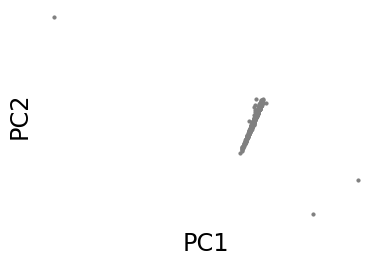

In [128]:
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c='grey',s=10);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

### two_species_ss

In [129]:
tau = (0,24,48)
topo = np.array([[0,1,2]])
trajs = []
for seed in tqdm(range(100)):
    traj = Trajectory(topo, tau,  model="two_species_ss", restrictions={}, verbose=0)
    traj = traj.fit(X, warm_start=False, params=params, n_init=1, perm_theta=False, parallel=True, epoch=10, n_threads=10, seed=seed)
    trajs.append(traj)

100%|██████████| 100/100 [45:43<00:00, 27.44s/it]


Text(0.5, 1.0, 'Random initialiazation')

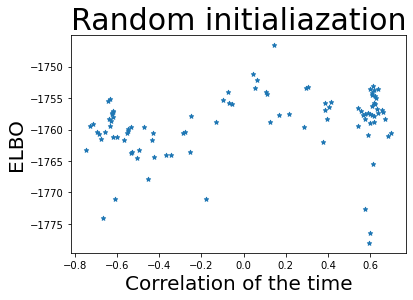

In [130]:
corrs = []
elbos = []
for traj in trajs:
    right_t = Q0[:,0] @ traj.t
    t_hat = traj.Q[:,0] @ traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20',s=20,marker='*')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)

In [131]:
tau = (0,24,48)
topo = np.array([[0,1,2]])
trajs = []
for seed in tqdm(range(100)):
    traj = Trajectory(topo, tau,  model="two_species_ss", restrictions={}, verbose=0)
    traj = traj.fit(X, warm_start=False, fit_tau=True, params=params, n_init=1, perm_theta=False, parallel=True, epoch=10, n_threads=10, seed=seed)
    trajs.append(traj)

100%|██████████| 100/100 [59:10<00:00, 35.50s/it]


Text(0.5, 1.0, 'Random initialiazation')

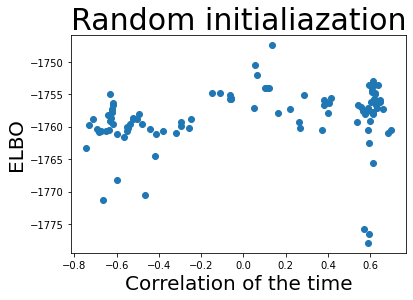

In [132]:
corrs = []
elbos = []
for traj in trajs:
    right_t = Q0[:,0] @ traj.t
    t_hat = traj.Q[:,0] @ traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)

In [133]:
traj = trajs[np.argmax(elbos)]
np.max(elbos)

-1747.4720938626226

[ 0.         24.16629377 48.        ]


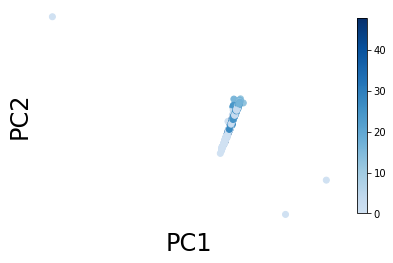

In [134]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

[]

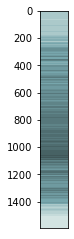

In [135]:
order = np.argsort(traj.Q[:,0]@traj.t)
cluster = np.zeros(adata.n_obs)
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    cluster[idx] = i
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
fig, ax = plt.subplots(1,1,figsize=(0.5,4))
ax.imshow(cluster[order,None],aspect="auto",cmap=cmap_cluster)
ax.set_xticks([])

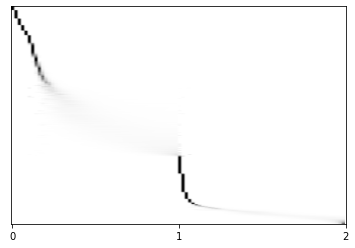

In [136]:
ax = plot_t(traj,l=0,order_cells=True)
x_label_list = ['0', '1', '2']
ax.set_xticks([0,50,100])
ax.set_xticklabels(x_label_list);
ax.set_yticks([]);

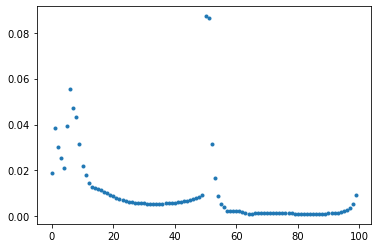

In [137]:
plt.plot(traj.Q.sum((0,1))/traj.Q.sum(),'.')

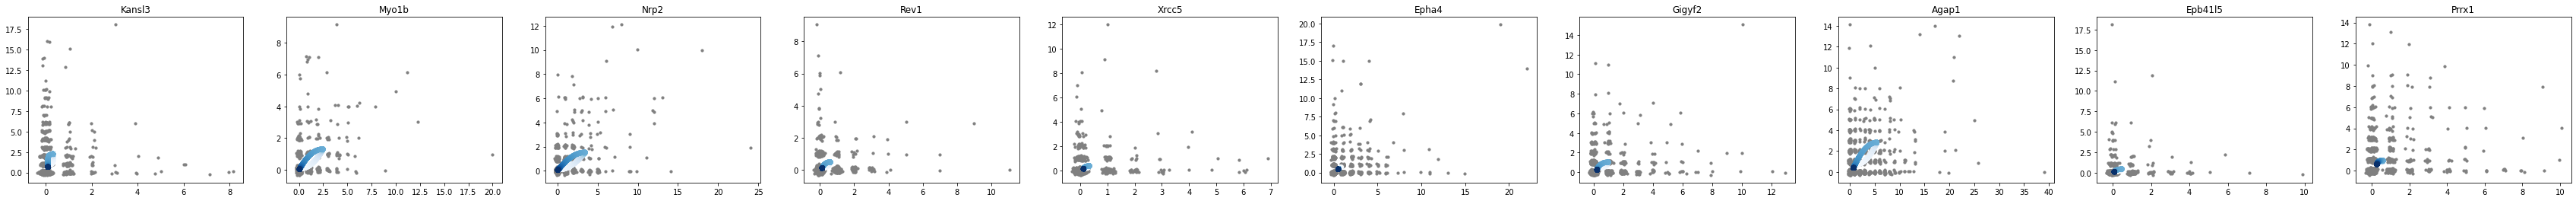

In [90]:
plot_phase(traj,idx=plot_idx,gene_name=fitted_genes);

29


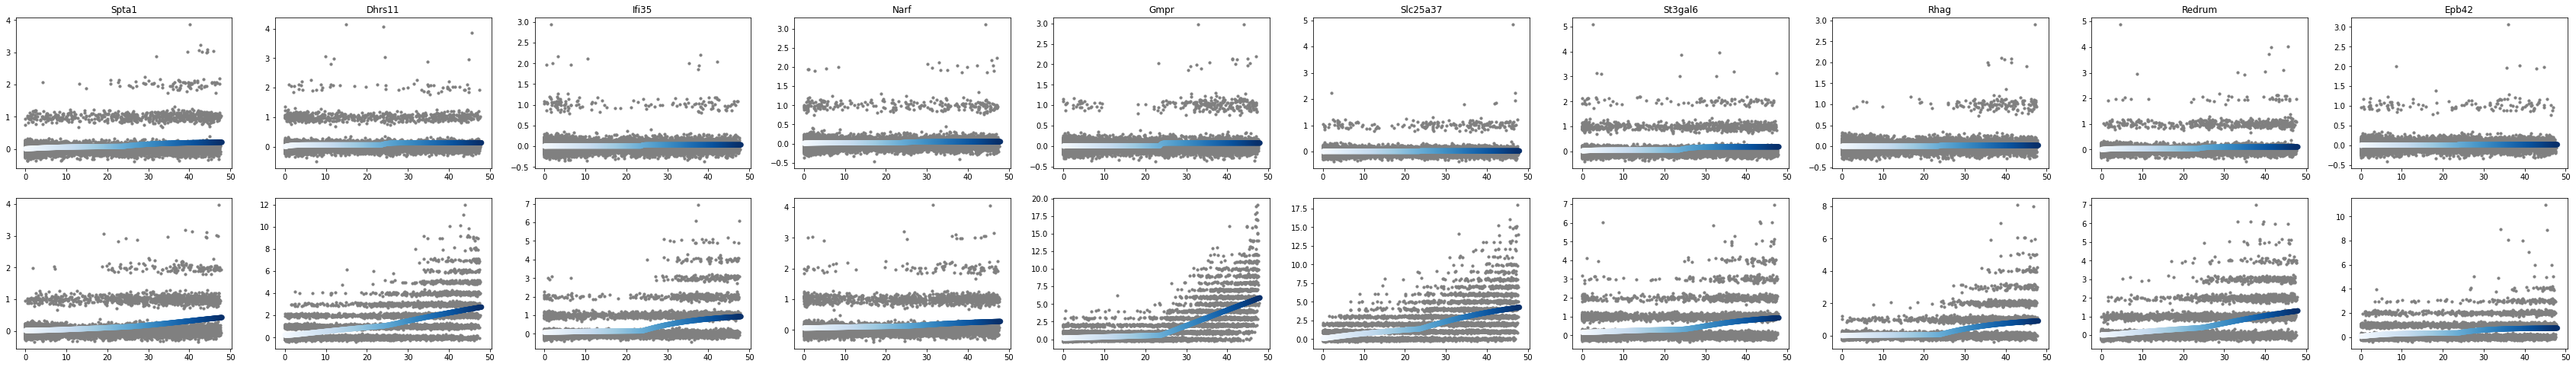

In [278]:
n, p, _ = X.shape
up_mask = (traj.theta[:,2] > 2*traj.theta[:,1]) & (traj.theta[:,1] > 2*traj.theta[:,0])
print(up_mask.sum())
up_idx = np.arange(p)[up_mask]
plot_y(traj,X=X,idx=up_idx[:10],gene_name=fitted_genes);

### two_species_ss_tau

In [228]:
tau = (0,24,48)
topo = np.array([[0,1,2]])
trajs = []
for seed in tqdm(range(20)):
    traj = Trajectory(topo, tau,  model="two_species_ss_tau", restrictions={}, verbose=0)
    traj = traj.fit(X, warm_start=False, params=params, n_init=1, perm_theta=False, parallel=True, epoch=10, n_threads=10, seed=seed)
    trajs.append(traj)

100%|██████████| 20/20 [20:21<00:00, 61.06s/it]


Text(0.5, 1.0, 'Random initialiazation')

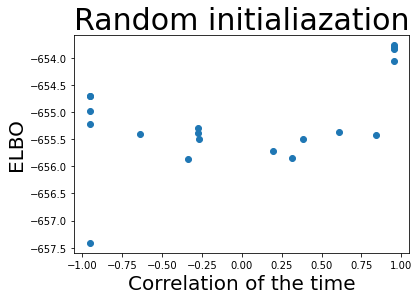

In [229]:
corrs = []
elbos = []
for traj in trajs:
    right_t = Q0[:,0] @ traj.t
    t_hat = traj.Q[:,0] @ traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)

In [235]:
traj = trajs[np.argmax(elbos)]

(array([171.,   4.,  17.,  12.,  18.,  34.,   9.,  23.,   9., 196.]),
 array([23.5, 23.6, 23.7, 23.8, 23.9, 24. , 24.1, 24.2, 24.3, 24.4, 24.5]),
 <BarContainer object of 10 artists>)

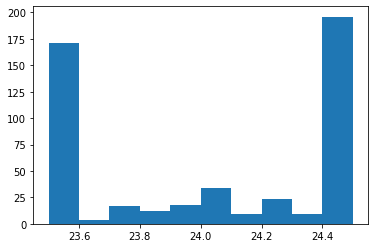

In [236]:
plt.hist(traj.theta[:,-3])

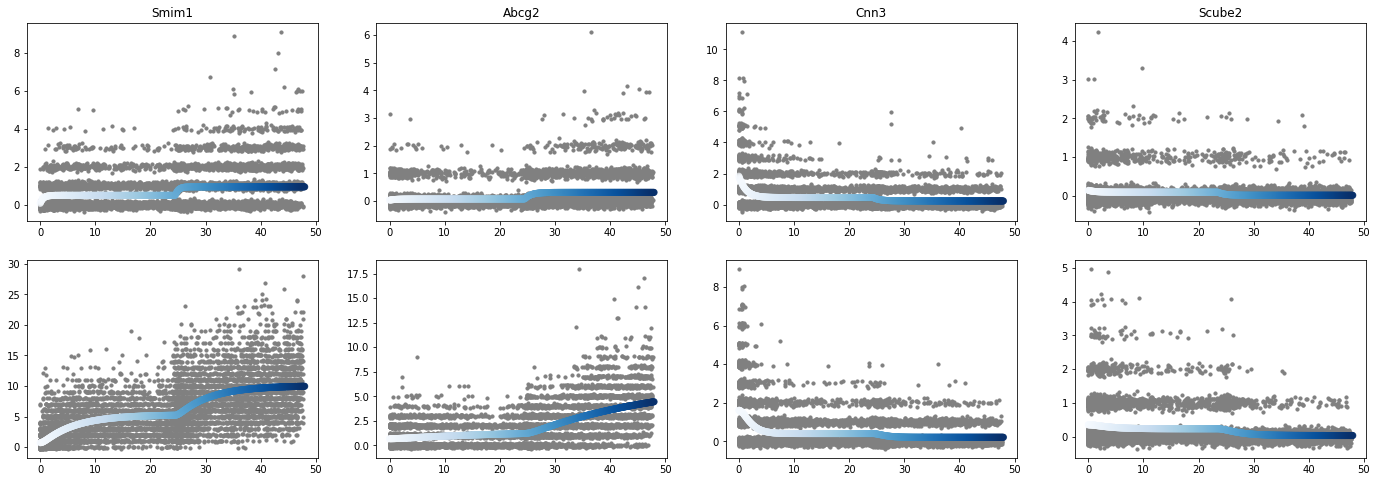

In [237]:
plot_y(traj,idx=plot_idx,gene_name=fitted_genes);

### two_species

In [242]:
tau = (0,24,48)
topo = np.array([[0,1,2]])
trajs = []
for seed in tqdm(range(100)):
    traj = Trajectory(topo, tau,  model="two_species", restrictions={}, verbose=0)
    traj = traj.fit(X, warm_start=False, fit_tau=True, params=params, n_init=1, perm_theta=False, parallel=True, epoch=10, n_threads=10, seed=seed)
    trajs.append(traj)

100%|██████████| 100/100 [2:02:24<00:00, 73.45s/it] 


Text(0.5, 1.0, 'Random initialiazation')

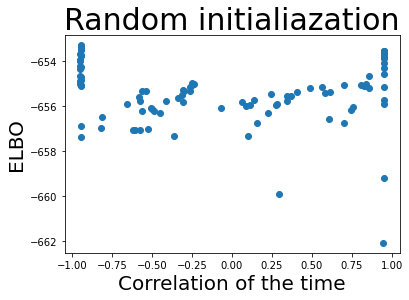

In [243]:
corrs = []
elbos = []
for traj in trajs:
    right_t = Q0[:,0] @ traj.t
    t_hat = traj.Q[:,0] @ traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)

In [257]:
traj = trajs[np.argmax(elbos)]
traj.elbos[0][-1]

-653.2902129127483

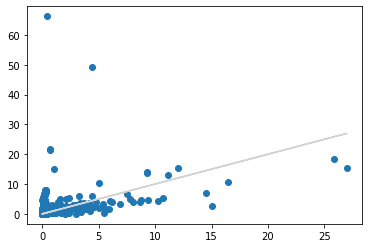

In [258]:
plt.scatter(traj.theta[:,-3],traj.theta[:,0]*traj.theta[:,-2]/traj.theta[:,-1])
plt.plot(traj.theta[:,-3],traj.theta[:,-3],color="lightgray")

In [259]:
traj = trajs[np.argmax(corrs)]
traj.elbos[0][-1]

-654.0742261573195

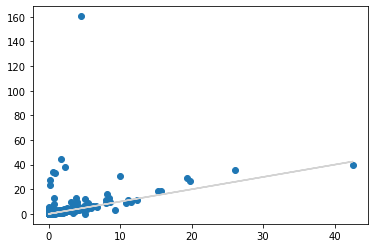

In [256]:
plt.scatter(traj.theta[:,-3],traj.theta[:,0]*traj.theta[:,-2]/traj.theta[:,-1])
plt.plot(traj.theta[:,-3],traj.theta[:,-3],color="lightgray")

# Synthetic data

In [299]:
m=100
weight0 = np.zeros((adata.n_obs,m))
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    weight0[idx,int(i*m/len(Clusters)):int((i+1)*m/len(Clusters))] += 1
weight0=weight0/weight0.sum(axis=1,keepdims=True)
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
Q0 = weight0[:,None]

topo = np.array([[0,1,2]])
tau = (0,24,48) # ~48 hours
traj = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj = traj.fit(X,warm_start=True,fit_tau=True,params=params,Q=Q0,parallel=True,n_threads=4,epoch=10)

fitting with warm start


100%|██████████| 10/10 [00:50<00:00,  5.08s/it]


In [301]:
print(traj.elbos[-1])

-658.4752472018502


[ 0.         23.94425778 48.        ]


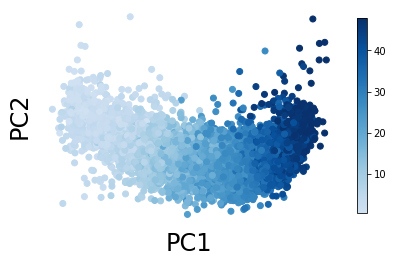

In [300]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

<AxesSubplot:>

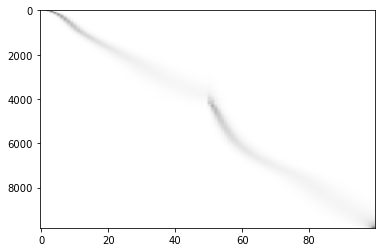

In [302]:
plot_t(traj,order_cells=True)

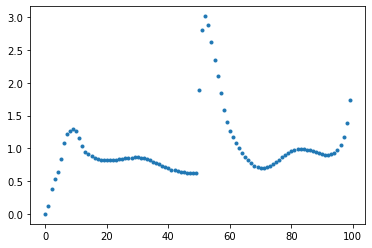

In [303]:
plt.plot(traj.Q.sum((0,1))/traj.Q.sum()*traj.m,'.')

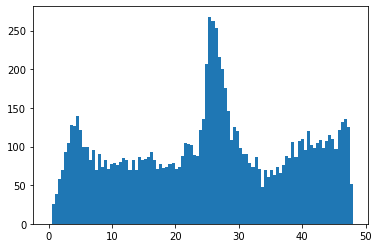

In [304]:
Y = traj.get_Y_hat(theta=traj.theta,t=traj.Q[:,0]@traj.t,tau=traj.tau,topo=traj.topo,params=traj.params)
syn_X = np.random.poisson(rd[:,None,None]*Y[0])
syn_t = traj.Q[:,0]@traj.t
plt.hist(syn_t,bins=traj.t);

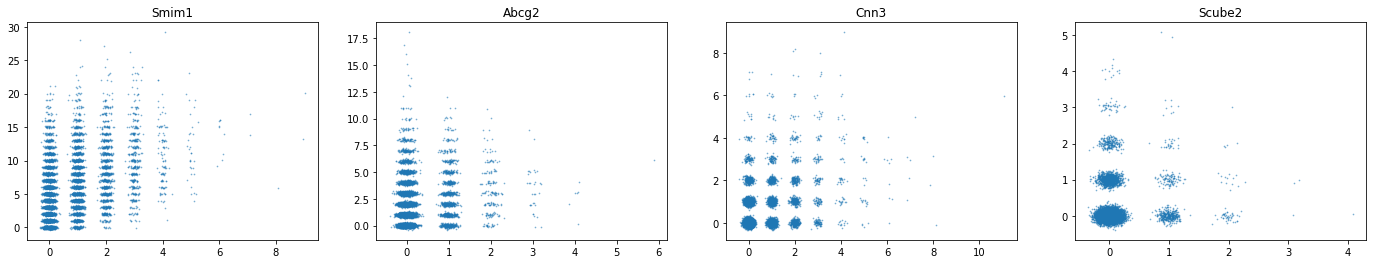

In [307]:
pp = min(10,len(plot_idx))
fix, ax = plt.subplots(1,pp,figsize=(6*pp,4))
for i in range(pp):
    j = plot_idx[i]
    ax[i].set_title(fitted_genes[j])
    ax[i].scatter(X[:,j,0]+np.random.normal(0,0.1,X.shape[0]),X[:,j,1]+np.random.normal(0,0.1,X.shape[0]),s=0.5,alpha=0.5) #,c=adata.obs['louvain'])

In [309]:
syn_tau = traj.tau.copy()
syn_topo = traj.topo.copy()
trajs = []
for seed in tqdm(range(20)):
    syn_traj = Trajectory(syn_topo, syn_tau,  model="two_species_ss", restrictions={}, verbose=0)
    syn_traj = syn_traj.fit(syn_X, warm_start=False, fit_tau=False, params=params, n_init=1, perm_theta=False, parallel=True, epoch=10, n_threads=4, seed=seed)
    trajs.append(syn_traj)

100%|██████████| 20/20 [12:44<00:00, 38.21s/it]


Text(0.5, 1.0, 'Random initialiazation')

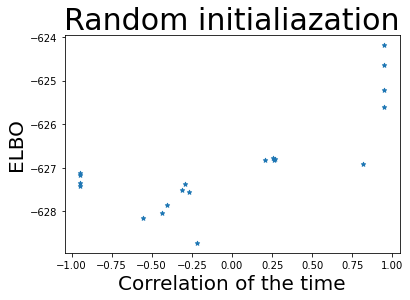

In [310]:
corrs = []
elbos = []
for syn_traj in trajs:
    right_t = syn_t
    t_hat = syn_traj.Q[:,0] @ syn_traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( syn_traj.elbos[np.argmax([syn_traj.elbos[i][-1] for i in range(len(syn_traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20',s=20,marker='*')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)